# GCN for predicting binding energy of transaminase mutants

    Use IGT or Spektral or any other form of GCN to predict the binding energy of a given transaminase mutant.

    The aim is to use binding energy data from 100,000 VfTA mutants (generated by Rosetta).

    Dataset is a set of 10,000 mutants of VfTA vs substrate 04S (alkyl chain)


In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import scipy
import GCN
import random
import spektral
from spektral.transforms.normalize_adj import NormalizeAdj  
import matplotlib.pyplot as plt

In [2]:
# prevent tensorflow from eating up all GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2024)])

2023-03-02 12:45:03.248231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 12:45:03.304702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 12:45:03.304776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Load enzyme and training datasets

In [3]:
# define some input information
pdb_reference = './dock/4e3q.pdb' # protein::ligand complex, ligand placed approximately in the binding site.
dataset_path = './datasets/D1.dat'# Dataset with mutant_id and energies
AAIndex = './AAIndex.csv'         # if not present, it will be built
active_site = {}                  # If not defined, it will be calculated
n_epochs = 40
es_patience = 5

In [4]:
# Downlaod and build `AAIndex.csv` if you don't already have it
if not os.path.isfile(AAIndex):
    import aaindex
    raw_filename = aaindex.download_aaindex()   
    df = aaindex.parse_aaindex(raw_filename)
    df.to_csv(AAIndex)

In [5]:
# Load dataset, find mutable positions, and split into train/val/test
mutable_pos = []

# option1: random list of features
features = random.sample(range(0, 560), 30) # random list of features
features.sort()

# option2: let's take the first 30 so it's easier to remember
features = [i for i in range(30)] 

In [6]:
# Load dataset to use for training and valiation
dataset, mean, std = GCN.load_dataset(dataset_path) # 'mutant', 'score'
mutable_pos = GCN.list_hotspots(list(dataset['mutant']))

Loaded and shuffled dataset from "./datasets/D1.dat" with 9050 mutants. mean=-12.3579 and std=1.1228 before normalization
Found 4 mutable positions: ['19', '150', '85', '57']


In [7]:
# Active site residues to create the nodes and edges
# option 1: Find residues that form the active site
active_site = GCN.find_active_site(mutable_pos, pdb_reference)

# option 2: Define the residues forming the binding site
active_site = {18: ('A','G'), 19: ('A','F'), 55: ('A','G'), 56: ('A','L'), 57: ('A','W'), 118: ('A','S'), 150: ('A','Y'),
               151: ('A','H'), 223: ('A','E'), 225: ('A','V'), 227: ('A','G'), 228: ('A','A'), 256: ('A','D'),
               257: ('A','E'), 415: ('A','R'), 417: ('A','L'), 424: ('A','C'), 82: ('B','Y'), 83: ('B','H'), 84: ('B','A'),
               85: ('B','F'), 86: ('B','F'), 88: ('B','R')}

Loaded pdb_reference='./dock/4e3q.pdb', found active_site={56: ('A', 'L'), 57: ('A', 'W'), 116: ('A', 'S'), 117: ('A', 'G'), 118: ('A', 'S'), 121: ('A', 'N'), 150: ('A', 'Y'), 151: ('A', 'H'), 152: ('A', 'G'), 223: ('A', 'E'), 228: ('A', 'A'), 256: ('A', 'D'), 258: ('A', 'V'), 259: ('A', 'I'), 285: ('A', 'K'), 415: ('A', 'R'), 417: ('A', 'L'), 85: ('B', 'F'), 86: ('B', 'F'), 321: ('B', 'F'), 322: ('B', 'T')}.


In [8]:
# E: Create the edge matrix using the structure of the protein-ligand complex (wild-type only)
distogram = GCN.generate_distogram(active_site, pdb_reference) # distogram.shape = (21,21) 21 is the number of nodes
edge_matrix = GCN.create_edgematrix(distogram)

# X: convert the training dataset to features using the AAindex
aaindex = GCN.load_aaindex(AAIndex)
mutants = dataset['mutant'].tolist()
labels = dataset['score'].tolist()
X = GCN.featurize_dataset(mutants, aaindex, features=features, active_site=active_site)

# Create datasets using X and E
enzdataset = GCN.EnzDataset(X, labels, edge_matrix, transforms=NormalizeAdj()) #enzdataset[0].x
loader_tr, loader_va, loader_te = GCN.create_loaders(enzdataset, batch_size=1, epochs=n_epochs, training=True, tr=80, val=20)

Loaded 559 AA properties from "./AAIndex.csv"
Created feature array X.shape=(9050, 23, 30) in 0.47 seconds


## Model building

In [9]:
# Build the model
X_in = tf.keras.layers.Input(shape=(enzdataset.n_node_features,), name='X_in')
A_in = tf.keras.layers.Input(shape=(None,), sparse=True, name='A_in')
X_1 = spektral.layers.GCSConv(64, activation='relu')((X_in, A_in))
pool1 , adj1 = spektral.layers.MinCutPool(k=10, activation='relu')([X_1, A_in])
X_2 = spektral.layers.GCSConv(8, activation='relu')([pool1, adj1])
pool2, adj2 = spektral.layers.MinCutPool(k=5, activation='relu')([X_2, adj1])
X_3 = spektral.layers.GlobalAvgPool()([pool2])
output = tf.keras.layers.Dense(1)(X_3) # output dimension is 1
model = tf.keras.models.Model(inputs = (X_in, A_in), outputs=output)

2023-03-02 12:45:14.966242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 12:45:14.967973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 12:45:14.968074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 12:45:14.968126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_in (InputLayer)              [(None, 30)]         0           []                               
                                                                                                  
 A_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 gcs_conv (GCSConv)             (None, 64)           3904        ['X_in[0][0]',                   
                                                                  'A_in[0][0]']                   
                                                                                                  
 min_cut_pool (MinCutPool)      [(10, 64),           650         ['gcs_conv[0][0]',           

## Training

In [11]:
# Define optimizers, loss and acc functions
loss_fn = tf.keras.losses.MeanSquaredError()
acc_fn = tf.keras.metrics.MeanAbsoluteError()
opt = tf.keras.optimizers.Adam()

In [12]:
train_model = True # Boolean
if train_model:
    loss, acc, val_loss, val_acc, best_weights = GCN.fit_model(model, loader_tr, loader_va, loss_fn, acc_fn, opt, es_patience)
    model.save_weights('best_weights.ckpt')
else:
    model.load_weights('best_weights.ckpt')

In [13]:
# save losses and accuracies
training_metrics='training_metrics.csv'
if train_model:
    df = pd.DataFrame(zip(loss, acc, val_loss, val_acc),columns=['train_loss','train_acc','val_loss','val_acc'])
    df.to_csv(training_metrics, index=False)
else:
    # Load csv 
    df = pd.read_csv(training_metrics)
    loss = df['train_loss'].tolist()
    acc = df['train_acc'].tolist()
    val_loss = df['val_loss'].tolist()
    val_acc = df['val_acc'].tolist()

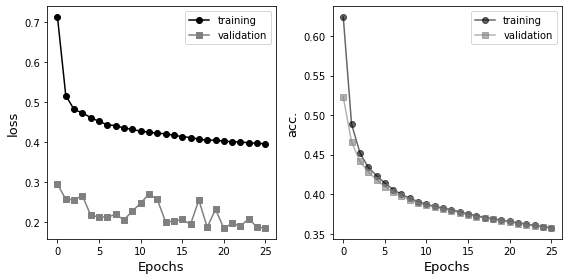

In [14]:
# Plot training metrics
from matplotlib.ticker import FormatStrFormatter

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Losses
axes[0].plot(loss, label='training', color='black', marker='o', markersize=6)
axes[0].plot(val_loss, label='validation', color='gray', marker='s', markersize=6)
axes[0].set_xlabel('Epochs', fontsize=13)
axes[0].set_ylabel('loss', color = 'black', fontsize=13)
axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].legend()

# Accuracies: fix bug
axes[1].plot(acc, label='training', color='black', marker='o', markersize=6, alpha=0.6)
axes[1].plot(val_acc, label='validation', color='gray', marker='s', markersize=6, alpha=0.6)
axes[1].set_xlabel('Epochs', fontsize=13)
axes[1].set_ylabel('acc.', fontsize=13)
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[1].legend()

# Show plot
fig.tight_layout()

## Evaluation performance trained model

In [13]:
def plot_regression(x, y, title):
    '''
    Plot the predicted vs ground truth figure. Include R2 and fit line.
    '''
    # Calculate the point density
    xy = np.vstack([x,y])
    z = scipy.stats.gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=20)

    # regression
    xseq = np.linspace(x.min(),x.max(), num=100)
    b, a = np.polyfit(x, y, deg=1)
    ax.plot(xseq, a + b * xseq, color="k", lw=2.0)
    res = scipy.stats.linregress(x, y)
    plt.text(0.08, 0.82, f'R-squared: {res.rvalue:.2f}', fontsize = 12, transform=ax.transAxes)
    plt.text(0.6, 0.20, f'y = {res.slope:.3f}x + {res.intercept:.3f}', fontsize = 11, transform=ax.transAxes)
    plt.text(0.6, 0.10, f'n={len(x)}', fontsize = 11, transform=ax.transAxes)
    plt.title(title, fontsize=13)
    ax.set_xlabel('target (kcal/mol)', fontsize=13)
    ax.set_ylabel('predicted (kcal/mol)', fontsize=13)

    fig.patch.set_facecolor('white')
    #plt.savefig(out_file, dpi=300)

    print (f'Printed plot {title=} (n={len(x)}) with R-squared: {res.rvalue:.2f}, slope: {res.slope:.3f}, and intercept: {res.intercept:.3f}')

Done with step 500
Done with step 1000
Done with step 1500
Done with step 2000
Done with step 2500
Done with step 3000
Done with step 3500
Done with step 4000
Done with step 4500
Done with step 5000
Done with step 5500
Done with step 6000
Done with step 6500
Done with step 7000
Printed plot title='Training dataset' (n=7240) with R-squared: 0.91, slope: 0.954, and intercept: -0.602
Done with step 500
Done with step 1000
Done with step 1500
Printed plot title='Validation' (n=1810) with R-squared: 0.91, slope: 0.966, and intercept: -0.458


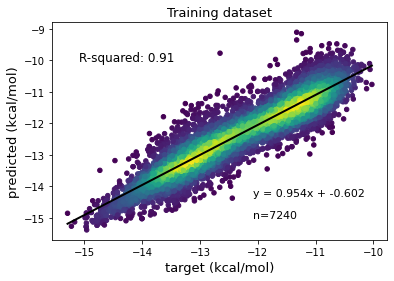

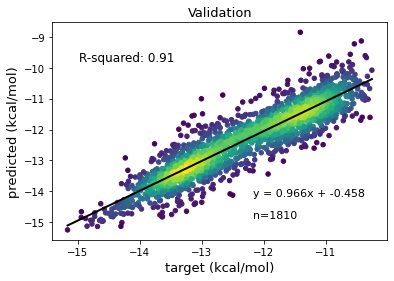

In [14]:
# Let's predict the scores of the test and validation datasets.
# create_loaders uses constant seed, so the split is exactly the same as it was before
loader_tr, loader_va, loader_te = GCN.create_loaders(enzdataset, batch_size=1, epochs=None, training=False, tr=80, val=20)

# Training dataset (80%)
preds, targets = GCN.evaluate_model(model, loader_tr)
preds = [(i * std )+ mean for i in preds] # Denormalize
targets = [(i * std )+ mean for i in targets]
plot_regression(x=np.array(preds), y=np.array(targets), title='Training dataset') 

# Validation dataset (20%)
preds, targets = GCN.evaluate_model(model, loader_va)
preds = [(i * std )+ mean for i in preds]
targets = [(i * std )+ mean for i in targets]
plot_regression(x=np.array(preds), y=np.array(targets), title='Validation') 

## Test with mutants the NN has never seen

In [15]:
# Test
# This is a list of mutants that were never shown to the neural network
mymutants=['Y150A_F19M_F85N_W57K','F85G_W57P','F19A_W57F_F85E_Y150F']

# We evaluate them:
preds = GCN.evaluate_mutants(mymutants, model=model, aaindex=aaindex, features=features, active_site=active_site,mutable_pos=mutable_pos, edge_matrix=edge_matrix, mean=mean, std=std)

# And here are the Rosetta calculations of those mutants that we did afterwards:
scores=[-11.1130, -13.5470, -14.0690]

# lets compare them
pd.DataFrame(zip(mymutants,preds, scores), columns=['mutant_id','pred. (kcal/mol)','Rosetta score (kcal/mol)'])

Created feature array X.shape=(3, 23, 30) in 0.00 seconds
Will not shuffle dataset with 3 mutants and tr=100, val=None, te=None.
Predicted score of 3 mutants in 0.09 seconds


mutant_id  pred. (kcal/mol)  Rosetta score (kcal/mol)
0  Y150A_F19M_F85N_W57K        -11.062905                   -11.113
1             F85G_W57P        -13.907684                   -13.547
2  F19A_W57F_F85E_Y150F        -14.211629                   -14.069

In [16]:
# WE can also evaluate another dataset of n=1000 mutants that were never shown to the NN during training
df = GCN.evaluate_custom_csv('./datasets/D1-extra.dat','out.csv', model=model, aaindex=aaindex, mutable_pos=False, features=features, active_site=active_site, edge_matrix=edge_matrix, mean=mean, std=std)
df

Created feature array X.shape=(1000, 23, 30) in 0.07 seconds
Will not shuffle dataset with 1000 mutants and tr=100, val=None, te=None.
Done with step 500
Done with step 1000
Predicted score of 1000 mutants in 27.39 seconds
Mean deviation was 0.3717321895044181 kcal/mol over the 1000 mutants evaluated.


mutant_id   score  predictions     error
0    Y150A_F19M_F85N_W57K -11.113   -11.062905 -0.050095
1              Y150I_F85A -13.813   -13.498218 -0.314782
2               F85G_W57P -13.547   -13.907684  0.360684
3    Y150D_W57F_F85Y_F19Y -12.320   -12.554872  0.234872
4              Y150P_F85L -12.954   -12.954342  0.000342
..                    ...     ...          ...       ...
995  F19V_Y150C_F85T_W57F -12.321   -11.929666 -0.391334
996             F85H_F19S -13.336   -13.523152  0.187152
997       F19C_Y150V_F85I -12.087   -11.932099 -0.154901
998  W57P_F85W_F19Y_Y150N -11.212   -10.980815 -0.231185
999       Y150V_W57N_F19S -10.502   -10.991230  0.489230

[1000 rows x 4 columns]

Printed plot title='Test dataset' (n=1000) with R-squared: 0.90, slope: 0.943, and intercept: -0.744


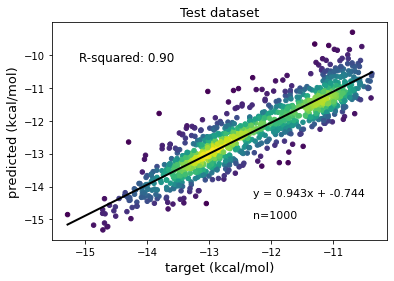

In [17]:
# let's make a plot of the 'D1-extra.dat' dataset to see how it looks:
preds = df['predictions']
targets=df['score']
plot_regression(x=np.array(preds), y=np.array(targets), title='Test dataset') 